 # Approach:

We will build a RFM clustering to identify different customers.

### Loading data

In [1]:
import os

# supress warnings
import warnings
warnings.filterwarnings('ignore')

#Importing Libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

Data Reading and Understanding

In [2]:
#function to read files (helps automate code)

def load_data():
    data_path = "C:/"
    
    file_1 = os.path.join(data_path, "customers.csv")
    file_2 = os.path.join(data_path, "items.csv")
    file_3 = os.path.join(data_path, "orders_.csv")
    file_4 = os.path.join(data_path, "trucks.csv")
    
    read_file_1 = pd.read_csv(file_1, encoding='utf8', header= 0)
    read_file_2 = pd.read_csv(file_2, encoding='utf8', header= 0)
    read_file_3 = pd.read_csv(file_3, encoding='utf8', header= 0)
    read_file_4 = pd.read_csv(file_4, encoding='utf8', header= 0)
    
    return (read_file_1, read_file_2, read_file_3, read_file_4)


In [3]:
#Reading data

customers, items, orders, trucks = load_data()

> ## Data Inspection

In [4]:
customers.head(10)

,customer_id,buyer_business_type,district_id,district_name_ar,city_name_en,area_name_ar,geo_latitude,geo_longitude,registration_date,avg_ticket_size,number_of_transactions,number_of_cancelled_transactions,last_order_date,total_orders_amount
0,47,اخري,100123.0,الهرم,Giza,الهرم,29.99344,31.15219,2020-07-06,523.786667,3.0,3.0,2020-11-12,1571.36
1,634,كشك,100140.0,مصر القديمة,Cairo,مصر القديمة,NaN,NaN,2020-01-20,2665.551667,6.0,4.0,2020-08-07,15993.31
2,841,اخري,100128.0,المعادي,Cairo,NaN,NaN,NaN,2020-01-23,1459.375000,6.0,2.0,2020-12-15,8756.25
3,863,اخري,100128.0,المعادي,Cairo,المعادي,NaN,NaN,2020-01-23,NaN,NaN,NaN,NaN,NaN
4,986,اخري,100125.0,حلوان,Cairo,المعصرة,29.84495,31.33025,2020-01-27,5618.270000,1.0,1.0,2020-06-14,5618.27
5,1008,كشك,100128.0,المعادي,Cairo,المعادي,NaN,NaN,2020-01-28,NaN,NaN,NaN,NaN,NaN
6,1068,اخري,100125.0,حلوان,Cairo,حدايق حلوان,NaN,NaN,2020-01-21,1989.783333,18.0,11.0,2021-03-01,35816.10
7,1119,اخري,100128.0,المعادي,Cairo,المعادي,NaN,NaN,2020-01-22,NaN,NaN,NaN,NaN,NaN
8,1492,اخري,100206.0,المريوطيه - فيصل,Giza,المريوطيه - فيصل,NaN,NaN,2020-01-28,5664.990000,5.0,1.0,2021-03-06,28324.95
9,1516,اخري,100000.0,Others,Cairo,Others,NaN,NaN,2020-01-28,NaN,NaN,NaN,NaN,NaN


In [5]:
customers.describe()

,customer_id,district_id,geo_latitude,geo_longitude,avg_ticket_size,number_of_transactions,number_of_cancelled_transactions,total_orders_amount
count,9814.000000,9803.000000,8142.000000,8142.000000,4627.000000,4627.000000,4627.000000,4.627000e+03
mean,11468.272774,100086.232276,30.168256,31.051191,2130.411682,4.795116,1.565593,1.651255e+04
std,6607.497550,2022.510166,1.095282,1.176232,2954.012527,8.353255,3.246430,1.776301e+05
min,6.000000,1.000000,-5.096980,-16.360670,4.300000,1.000000,0.000000,4.300000e+00
25%,6049.500000,100119.000000,30.011608,31.180060,860.836000,1.000000,0.000000,1.691085e+03
50%,10982.500000,100128.000000,30.080700,31.217100,1423.868889,3.000000,1.000000,4.251890e+03
75%,16641.250000,100143.000000,30.135307,31.282128,2428.625000,5.000000,2.000000,1.039473e+04
max,35453.000000,100218.000000,38.760990,31.537000,94059.175368,253.000000,92.000000,8.935622e+06


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9814 entries, 0 to 9813
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       9814 non-null   int64  
 1   buyer_business_type               9801 non-null   object 
 2   district_id                       9803 non-null   float64
 3   district_name_ar                  9803 non-null   object 
 4   city_name_en                      9803 non-null   object 
 5   area_name_ar                      9403 non-null   object 
 6   geo_latitude                      8142 non-null   float64
 7   geo_longitude                     8142 non-null   float64
 8   registration_date                 9814 non-null   object 
 9   avg_ticket_size                   4627 non-null   float64
 10  number_of_transactions            4627 non-null   float64
 11  number_of_cancelled_transactions  4627 non-null   float64
 12  last_o

    customers has many observations missing values with respect to multiple features

In [7]:
items.head(10)

,item_id,length,width,height
0,226,17.0,40.0,33.0
1,223,16.0,34.0,34.0
2,634,15.0,43.0,30.0
3,25,16.0,34.0,30.0
4,56,16.0,38.5,29.5
5,1330,15.0,32.0,39.0
6,362,27.0,39.5,30.0
7,54,47.0,48.5,31.0
8,198,19.0,39.0,23.5
9,97,38.0,31.0,28.5


In [8]:
items.describe()

,item_id,length,width,height
count,628.000000,614.000000,614.000000,614.000000
mean,469.328025,21.666124,35.644951,24.612378
std,383.277589,7.765009,7.861266,7.567127
min,12.000000,6.000000,17.000000,5.000000
25%,193.250000,15.500000,31.000000,19.000000
50%,368.000000,20.000000,35.000000,24.000000
75%,668.500000,25.500000,40.000000,29.000000
max,1393.000000,47.000000,62.000000,57.000000


In [9]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  628 non-null    int64  
 1   length   614 non-null    float64
 2   width    614 non-null    float64
 3   height   614 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 19.8 KB


    items has 14 observations missing values

In [10]:
orders.head(10)

,Order_ID,item_id,customer_id,Order_date,total_ITem_amount,requested_quantity
0,ORD-3880388,226,34506,2020-09-21,94.0,1
1,ORD-3880388,223,34506,2020-09-21,94.0,1
2,ORD-3880388,634,34506,2020-09-21,233.0,1
3,ORD-3880388,25,34506,2020-09-21,119.0,2
4,ORD-3880388,56,34506,2020-09-21,119.0,1
5,ORD-3880388,1330,34506,2020-09-21,220.0,2
6,ORD-3880388,362,34506,2020-09-21,106.0,1
7,ORD-3880388,54,34506,2020-09-21,285.0,1
8,ORD-6883851,198,34122,2020-09-22,1064.0,8
9,ORD-6883851,97,34122,2020-09-22,347.5,5


In [11]:
orders.describe()

,item_id,customer_id,total_ITem_amount,requested_quantity
count,628.000000,628.000000,628.00000,628.000000
mean,469.328025,25228.211783,243.66051,2.934713
std,383.277589,9188.763468,526.37111,4.361336
min,12.000000,5966.000000,9.00000,1.000000
25%,193.250000,16291.000000,58.26000,1.000000
50%,368.000000,27166.000000,104.50000,2.000000
75%,668.500000,33786.000000,235.50000,3.000000
max,1393.000000,35409.000000,7142.40000,50.000000


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Order_ID            628 non-null    object 
 1   item_id             628 non-null    int64  
 2   customer_id         628 non-null    int64  
 3   Order_date          628 non-null    object 
 4   total_ITem_amount   628 non-null    float64
 5   requested_quantity  628 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 29.6+ KB


    orders has no missing values

In [13]:
trucks.describe()

,truck_ID,length,width,height
count,4.000000,4.0,4.0,4.0
mean,2.500000,222.5,152.5,152.5
std,1.290994,15.0,35.0,25.0
min,1.000000,200.0,100.0,115.0
25%,1.750000,222.5,152.5,152.5
50%,2.500000,230.0,170.0,165.0
75%,3.250000,230.0,170.0,165.0
max,4.000000,230.0,170.0,165.0


In [14]:
trucks.head(10)

,truck_ID,length,width,height
0,1,230,170,165
1,2,230,170,165
2,3,230,170,165
3,4,200,100,115


In [15]:
trucks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   truck_ID  4 non-null      int64
 1   length    4 non-null      int64
 2   width     4 non-null      int64
 3   height    4 non-null      int64
dtypes: int64(4)
memory usage: 256.0 bytes


    trucks has no missing values

   ----------------------------------------------------------------------------------------------
   * * * 

> ## Extracting new features

### RFM
#### Extracting R (Recency), F (Frequency), M (Monetary) columns form the data.

In [16]:
#RFM implementation

#Extracting amount by multiplying quantity of tickets and average ticket size 
#and saving the data into amount variable.
ticket_count = customers['number_of_transactions'] - customers['number_of_cancelled_transactions'] 

customers["amount"]  =  ticket_count * customers['avg_ticket_size']
#customers.total_orders_amount * customers.avg_ticket_size

#### Monetary Value

In [17]:
# Monetary Function

# Finding total amount spent per customer
monetary = customers.groupby("customer_id").amount.sum()
monetary = monetary.reset_index()
monetary.head()

,customer_id,amount
0,6,0.0
1,43,0.0
2,44,0.0
3,45,0.0
4,47,0.0


#### Frequency Value

In [41]:
#Frequency function

# Getting the count of orders made by each customer based on customer ID.
customers['frequency'] = customers['total_orders_amount']
frequency = customers.groupby("customer_id").frequency.count()
frequency = frequency.reset_index()
frequency.head()

,customer_id,frequency
0,6,0
1,43,0
2,44,0
3,45,0
4,47,1


Merging Amount and Frequency columns

In [42]:
#creating master dataset
master = monetary.merge(frequency, on = "customer_id", how = "inner")
master.head()

,customer_id,amount,frequency
0,6,0.0,0
1,43,0.0,0
2,44,0.0,0
3,45,0.0,0
4,47,0.0,1


#### Recency Value

In [43]:
#first imputing missing date values in last_order_date
customers['last_order_date'].fillna(pd.Timedelta(seconds=0))

0       2020-11-12 00:00:00
1       2020-08-07 00:00:00
2       2020-12-15 00:00:00
3           0 days 00:00:00
4       2020-06-14 00:00:00
               ...         
9809        0 days 00:00:00
9810        0 days 00:00:00
9811        0 days 00:00:00
9812    2021-02-22 00:00:00
9813    2021-01-28 00:00:00
Name: last_order_date, Length: 9814, dtype: object

In [44]:
customers.head()

,customer_id,buyer_business_type,district_id,district_name_ar,city_name_en,area_name_ar,geo_latitude,geo_longitude,registration_date,avg_ticket_size,number_of_transactions,number_of_cancelled_transactions,last_order_date,total_orders_amount,amount,difference,frequency
0,47,اخري,100123.0,الهرم,Giza,الهرم,29.99344,31.15219,2020-07-06,523.786667,3.0,3.0,2020-11-12,1571.36,0.000000,126 days,1571.36
1,634,كشك,100140.0,مصر القديمة,Cairo,مصر القديمة,NaN,NaN,2020-01-20,2665.551667,6.0,4.0,2020-08-07,15993.31,5331.103333,223 days,15993.31
2,841,اخري,100128.0,المعادي,Cairo,NaN,NaN,NaN,2020-01-23,1459.375000,6.0,2.0,2020-12-15,8756.25,5837.500000,93 days,8756.25
3,863,اخري,100128.0,المعادي,Cairo,المعادي,NaN,NaN,2020-01-23,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN
4,986,اخري,100125.0,حلوان,Cairo,المعصرة,29.84495,31.33025,2020-01-27,5618.270000,1.0,1.0,2020-06-14,5618.27,0.000000,277 days,5618.27


Working with dataset in interest(customers) for clustering customers

In [45]:
# parse date

customers['last_order_date'] = pd.to_datetime(customers[
    'last_order_date'], format = "%Y-%m-%d")

customers['registration_date'] = pd.to_datetime(customers[
    'registration_date'], format = "%Y-%m-%d")

customers.head()


,customer_id,buyer_business_type,district_id,district_name_ar,city_name_en,area_name_ar,geo_latitude,geo_longitude,registration_date,avg_ticket_size,number_of_transactions,number_of_cancelled_transactions,last_order_date,total_orders_amount,amount,difference,frequency
0,47,اخري,100123.0,الهرم,Giza,الهرم,29.99344,31.15219,2020-07-06,523.786667,3.0,3.0,2020-11-12,1571.36,0.000000,126 days,1571.36
1,634,كشك,100140.0,مصر القديمة,Cairo,مصر القديمة,NaN,NaN,2020-01-20,2665.551667,6.0,4.0,2020-08-07,15993.31,5331.103333,223 days,15993.31
2,841,اخري,100128.0,المعادي,Cairo,NaN,NaN,NaN,2020-01-23,1459.375000,6.0,2.0,2020-12-15,8756.25,5837.500000,93 days,8756.25
3,863,اخري,100128.0,المعادي,Cairo,المعادي,NaN,NaN,2020-01-23,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN
4,986,اخري,100125.0,حلوان,Cairo,المعصرة,29.84495,31.33025,2020-01-27,5618.270000,1.0,1.0,2020-06-14,5618.27,0.000000,277 days,5618.27


In [46]:
# Finding max data
maximum = max(customers.last_order_date)


In [47]:
# Adding one more day to the max data,
#so that the max date will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days = 1)


In [48]:
customers['difference'] = maximum - customers.last_order_date
customers.head()

,customer_id,buyer_business_type,district_id,district_name_ar,city_name_en,area_name_ar,geo_latitude,geo_longitude,registration_date,avg_ticket_size,number_of_transactions,number_of_cancelled_transactions,last_order_date,total_orders_amount,amount,difference,frequency
0,47,اخري,100123.0,الهرم,Giza,الهرم,29.99344,31.15219,2020-07-06,523.786667,3.0,3.0,2020-11-12,1571.36,0.000000,126 days,1571.36
1,634,كشك,100140.0,مصر القديمة,Cairo,مصر القديمة,NaN,NaN,2020-01-20,2665.551667,6.0,4.0,2020-08-07,15993.31,5331.103333,223 days,15993.31
2,841,اخري,100128.0,المعادي,Cairo,NaN,NaN,NaN,2020-01-23,1459.375000,6.0,2.0,2020-12-15,8756.25,5837.500000,93 days,8756.25
3,863,اخري,100128.0,المعادي,Cairo,المعادي,NaN,NaN,2020-01-23,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN
4,986,اخري,100125.0,حلوان,Cairo,المعصرة,29.84495,31.33025,2020-01-27,5618.270000,1.0,1.0,2020-06-14,5618.27,0.000000,277 days,5618.27


In [49]:
#Dataframe merging by recency
recency = customers.groupby('customer_id').difference.min()
recency = recency.reset_index()
recency.head()



,customer_id,difference
0,6,NaT
1,43,NaT
2,44,NaT
3,45,NaT
4,47,126 days



#### RFM combined DataFrame


In [50]:
master

,customer_id,amount,frequency
0,6,0.000,0
1,43,0.000,0
2,44,0.000,0
3,45,0.000,0
4,47,0.000,1
...,...,...,...
9805,35416,8997.058,1
9806,35435,2325.520,1
9807,35448,3425.390,1
9808,35451,26855.870,1


In [51]:
#Combining all recency, frequency and monetary parameters
RFM = master.merge(recency, on = "customer_id")
RFM.columns = ['customer_id','amount','frequency','recency']
RFM.head()



,customer_id,amount,frequency,recency
0,6,0.0,0,NaT
1,43,0.0,0,NaT
2,44,0.0,0,NaT
3,45,0.0,0,NaT
4,47,0.0,1,126 days


In [52]:
RFM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9810 entries, 0 to 9809
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   customer_id  9810 non-null   int64          
 1   amount       9810 non-null   float64        
 2   frequency    9810 non-null   int64          
 3   recency      4625 non-null   timedelta64[ns]
dtypes: float64(1), int64(2), timedelta64[ns](1)
memory usage: 383.2 KB


  Outlier Treatment

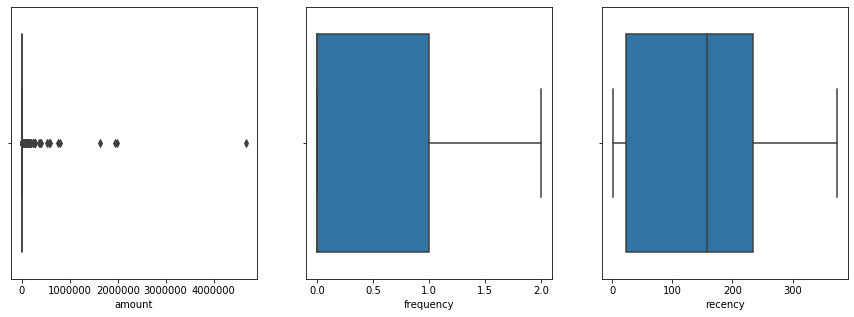

In [53]:
# outlier treatment for Amount
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(RFM.amount, ax = axs[0])
sns.boxplot(RFM.frequency, ax = axs[1])
sns.boxplot(RFM.recency.dt.days, ax = axs[2])

plt.tight_layout
plt.show()

In [54]:
# outlier treatment for Amount
Q1 = RFM.amount.quantile(0.25)
Q3 = RFM.amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.amount >= Q1 - 1.5*IQR) & (RFM.amount <= Q3 + 1.5*IQR)]

In [55]:
# outlier treatment for Frequency
Q1 = RFM.frequency.quantile(0.25)
Q3 = RFM.frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.frequency >= Q1 - 1.5*IQR) & (RFM.frequency <= Q3 + 1.5*IQR)]



In [56]:
# outlier treatment for Recency
Q1 = RFM.recency.quantile(0.25)
Q3 = RFM.recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.recency >= Q1 - 1.5*IQR) & (RFM.recency <= Q3 + 1.5*IQR)]


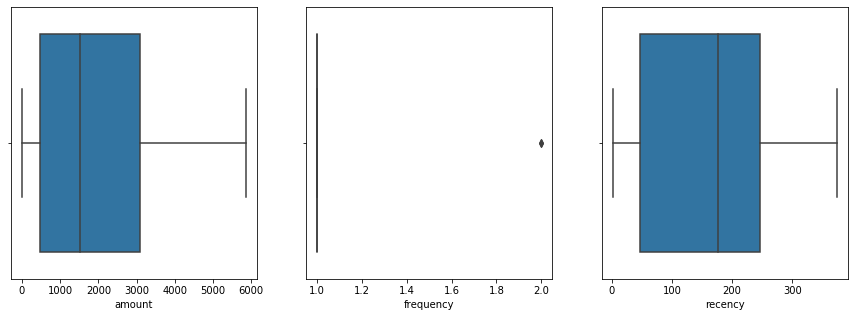

In [57]:
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(RFM.amount, ax = axs[0])
sns.boxplot(RFM.frequency, ax = axs[1])
sns.boxplot(RFM.recency.dt.days, ax = axs[2])

plt.tight_layout
plt.show()

In [58]:
RFM.head()


,customer_id,amount,frequency,recency
4,47,0.00,1,126 days
5,56,1736.12,1,14 days
8,67,0.00,1,253 days
9,68,2427.25,1,101 days
10,620,0.00,1,245 days


#### Scaling the RFM data

In [59]:
# standardise all parameters
RFM_norm1 = RFM.drop("customer_id", axis=1)
RFM_norm1.recency = RFM_norm1.recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [60]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['frequency','amount','recency']
RFM_norm1.head()

,frequency,amount,recency
0,-1.133024,-0.024448,-0.377960
1,-0.092670,-0.024448,-1.448681
2,-1.133024,-0.024448,0.836161
3,0.321483,-0.024448,-0.616960
4,-1.133024,-0.024448,0.759681


#### Hopkins Statistics:
he Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

* If the value is between {0.01, ...,0.3}, the data is regularly spaced.  
* If the value is around 0.5, it is random.  
* If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.  


In [61]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [62]:
hopkins(RFM_norm1)

0.9973064070382586

#### K-Means with some K

To find the best K, we will use __Silhouette Analysis__

silhouette score=p−qmax(p,q)  
p is the mean distance to the points in the nearest cluster that the data point is not a part of  
q is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1.  
* A score closer to 1 indicates that the data point is very similar to other data points in the cluster,  
* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.


In [63]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])



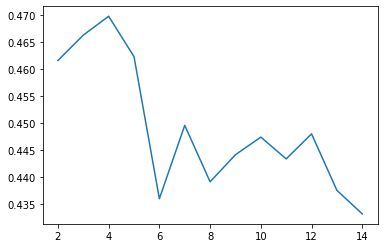

In [64]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

#### Sum of Squared Distances

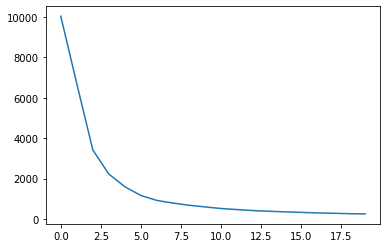

In [65]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=100)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [68]:
# Kmeans with K=3
model_clus3 = KMeans(n_clusters = 3, max_iter=50)
model_clus3.fit(RFM_norm1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [70]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus3.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'amount', 'frequency', 'recency', 'ClusterID']
RFM_km.head()

,CustomerID,amount,frequency,recency,ClusterID
0,47,0.00,1,126 days,0
1,56,1736.12,1,14 days,1
2,67,0.00,1,253 days,0
3,68,2427.25,1,101 days,1
4,620,0.00,1,245 days,0


In [71]:
RFM_km.recency = RFM_km.recency.dt.days
km_clusters_amount = pd.DataFrame(RFM_km.groupby(["ClusterID"]).amount.mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).recency.mean())

In [72]:
df = pd.concat([pd.Series([0,1,2]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,1078.252920,1,228.103746
1,1,3229.268156,1,62.488924
2,2,1784.252000,2,157.500000


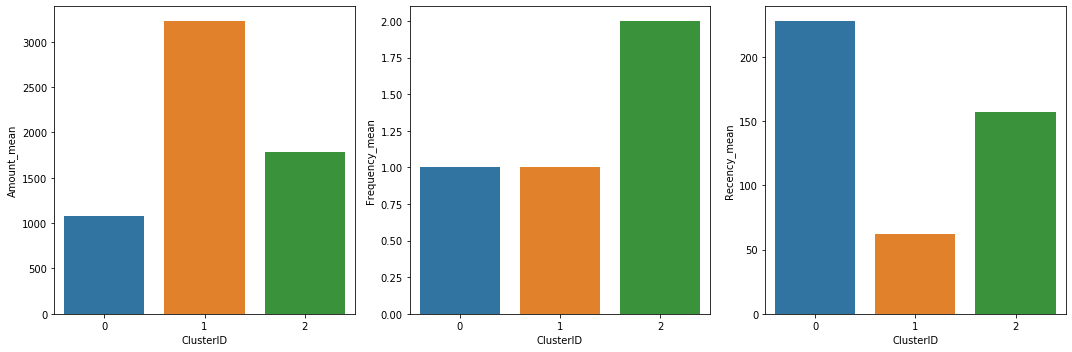

In [73]:
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.barplot(x=df.ClusterID, y=df.Amount_mean, ax = axs[0])
sns.barplot(x=df.ClusterID, y=df.Frequency_mean, ax = axs[1])
sns.barplot(x=df.ClusterID, y=df.Recency_mean, ax = axs[2])
plt.tight_layout()            
plt.show()

   ----------------------------------------------------------------------------------------------
   * * * 


> ## Inferences

>    - On RFM analysis it was found that Customers with Cluster ID 1 are the best, most buyers and loyal 
customers. They aren't the ones who need many promotions and if any, it could be for individual products.
   - Cluster Id 0 are customers who are used COMPANY's app a few times and not interested
    using it. We could investigate their experiences with us and offer them incetive promotions. This
    customers needs targeted marketing marketing based on their demographics, buying pattern etc.  
   - People with cluster ID 2 are customers who are frequently using the app but with low amount of orders. We could give them promotions for bulk orders.



   ----------------------------------------------------------------------------------------------
   * * * 

#### Exporting the model on csv file

In [1]:
model = RFM_km
model.to_csv("D:/")

NameError: name 'RFM_km' is not defined

> *And this could be handled*